In [1]:
import sys
sys.path.append('../cyx＆xy/bert')

In [ ]:
from sklearn.model_selection import train_test_split
f=open('../cyx＆xy/bert/THUCNews/data/all_data_with_label1.txt','r',encoding='utf-8')
data=f.readlines()
f.close()

In [ ]:
train_set,test_set=train_test_split(data,test_size=0.4)
dev_set,test_set=train_test_split(test_set,test_size=0.4)

In [ ]:
f=open('../cyx＆xy/bert/THUCNews/data/train.txt','w',encoding='utf-8')
for i in train_set:
    f.write(i)
f.close()

f=open('../cyx＆xy/bert/THUCNews/data/dev.txt','w',encoding='utf-8')
for i in dev_set:
    f.write(i)
f.close()

f=open('../cyx＆xy/bert/THUCNews/data/test.txt','w',encoding='utf-8')
for i in test_set:
    f.write(i)
f.close()

In [8]:
# coding: UTF-8
import torch
import torch.nn as nn
# from pytorch_pretrained_bert import BertModel, BertTokenizer
from pytorch_pretrained import BertModel, BertTokenizer


class Config(object):

    """配置参数"""
    def __init__(self, dataset):
        self.model_name = 'bert'
        self.train_path = dataset + '/data/train.txt'                                # 训练集
        self.dev_path = dataset + '/data/dev.txt'                                    # 验证集
        self.test_path = dataset + '/data/test.txt'                                  # 测试集
        self.class_list = [x.strip() for x in open(
            dataset + '/data/class_my.txt').readlines()]                                # 类别名单
        self.save_path = dataset + '/saved_dict/' + self.model_name + '_without_my.ckpt'        # 模型训练结果
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # 设备

        self.require_improvement = 10000                                 # 若超过1000batch效果还没提升，则提前结束训练
        self.num_classes = len(self.class_list)                         # 类别数
        #self.num_epochs = 3                                             # epoch数
        self.num_epochs = 30
        #self.batch_size = 128
        self.batch_size = 8                                           # mini-batch大小
        self.pad_size = 32                                              # 每句话处理成的长度(短填长切)
        self.learning_rate = 4e-6                                       # 学习率
        self.bert_path = 'bert-base-chinese'
        self.tokenizer = BertTokenizer.from_pretrained(self.bert_path)
        self.hidden_size = 768


class Model(nn.Module):

    def __init__(self, config):
        super(Model, self).__init__()
        self.bert = BertModel.from_pretrained(config.bert_path)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.fc = nn.Linear(config.hidden_size, config.num_classes)

    def forward(self, x):
        context = x[0]  # 输入的句子
        mask = x[2]  # 对padding部分进行mask，和句子一个size，padding部分用0表示，如：[1, 1, 1, 1, 0, 0]
        _, pooled = self.bert(context, attention_mask=mask, output_all_encoded_layers=False)
        out = self.fc(pooled)
        return out


In [9]:
# coding: UTF-8
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
import time
from utils import get_time_dif
from pytorch_pretrained.optimization import BertAdam


# 权重初始化，默认xavier
def init_network(model, method='xavier', exclude='embedding', seed=123):
    for name, w in model.named_parameters():
        if exclude not in name:
            if len(w.size()) < 2:
                continue
            if 'weight' in name:
                if method == 'xavier':
                    nn.init.xavier_normal_(w)
                elif method == 'kaiming':
                    nn.init.kaiming_normal_(w)
                else:
                    nn.init.normal_(w)
            elif 'bias' in name:
                nn.init.constant_(w, 0)
            else:
                pass


def train(config, model, train_iter, dev_iter, test_iter):
    start_time = time.time()
    model.train()
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=config.learning_rate,
                         warmup=0.05,
                         t_total=len(train_iter) * config.num_epochs)
    total_batch = 0  # 记录进行到多少batch
    dev_best_loss = float('inf')
    last_improve = 0  # 记录上次验证集loss下降的batch数
    flag = False  # 记录是否很久没有效果提升
    model.train()
    train_log=[]
    dev_log=[]
    
    for epoch in range(config.num_epochs):
        loss_temp = 0
        dev_temp = []
        print('Epoch [{}/{}]'.format(epoch + 1, config.num_epochs))
        for i, (trains, labels) in enumerate(train_iter):
            outputs = model(trains)
            model.zero_grad()
            loss = F.cross_entropy(outputs, labels)
            loss_temp += loss
            loss.backward()
            optimizer.step()
            #if total_batch % 100 == 0:
            if total_batch % 10 == 0:
                # 每多少轮输出在训练集和验证集上的效果
                true = labels.data.cpu()
                predic = torch.max(outputs.data, 1)[1].cpu()
                train_acc = metrics.accuracy_score(true, predic)
                dev_acc, dev_loss = evaluate(config, model, dev_iter)
                if dev_loss < dev_best_loss:
                    dev_best_loss = dev_loss
                    torch.save(model.state_dict(), config.save_path)
                    improve = '*'
                    last_improve = total_batch
                else:
                    improve = ''
                time_dif = get_time_dif(start_time)
                msg = 'Iter: {0:>6},  Train Loss: {1:>5.2},  Train Acc: {2:>6.2%},  Val Loss: {3:>5.2},  Val Acc: {4:>6.2%},  Time: {5} {6}'
                print(msg.format(total_batch, loss.item(), train_acc, dev_loss, dev_acc, time_dif, improve))
                dev_temp.append(dev_loss.item())
                model.train()
            total_batch += 1
            if total_batch - last_improve > config.require_improvement:
                # 验证集loss超过1000batch没下降，结束训练
                print("No optimization for a long time, auto-stopping...")
                flag = True
                break
        print('--------------')
        print(dev_temp)   
        dev_acc, dev_loss = evaluate(config, model, dev_iter)
        dev_log.append(dev_temp)
        train_log.append(loss_temp)
        if flag:
            break
    test(config, model, test_iter)
    return dev_log,train_log


def test(config, model, test_iter):
    # test
    model.load_state_dict(torch.load(config.save_path))
    model.eval()
    start_time = time.time()
    test_acc, test_loss, test_report, test_confusion = evaluate(config, model, test_iter, test=True)
    msg = 'Test Loss: {0:>5.2},  Test Acc: {1:>6.2%}'
    print(msg.format(test_loss, test_acc))
    print("Precision, Recall and F1-Score...")
    print(test_report)
    print("Confusion Matrix...")
    print(test_confusion)
    time_dif = get_time_dif(start_time)
    print("Time usage:", time_dif)


def evaluate(config, model, data_iter, test=False):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    with torch.no_grad():
        for texts, labels in data_iter:
            outputs = model(texts)
            loss = F.cross_entropy(outputs, labels)
            loss_total += loss
            labels = labels.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)

    acc = metrics.accuracy_score(labels_all, predict_all)
    if test:
        report = metrics.classification_report(labels_all, predict_all, target_names=config.class_list, digits=4)
        confusion = metrics.confusion_matrix(labels_all, predict_all)
        return acc, loss_total / len(data_iter), report, confusion
    return acc, loss_total / len(data_iter)


In [10]:
# coding: UTF-8
import time
import torch
import numpy as np
#from train_eval import train, init_network
import argparse
from utils import build_dataset, build_iterator, get_time_dif

parser = argparse.ArgumentParser(description='Chinese Text Classification')
#parser.add_argument('--model', type=str, required=True, help='choose a model: Bert, ERNIE')
parser.add_argument('--model',default='bert',help='Bert')
#args = parser.parse_args()
args = parser.parse_args(args=[])


if __name__ == '__main__':
    dataset = '../cyx＆xy/bert/THUCNews'  # 数据集

    model_name = args.model  # bert
    config = Config(dataset)
    np.random.seed(2)
    torch.manual_seed(2)
    torch.cuda.manual_seed_all(2)
    torch.backends.cudnn.deterministic = True  # 保证每次结果一样

    start_time = time.time()
    print("Loading data...")
    train_data, dev_data, test_data = build_dataset(config)
    train_iter = build_iterator(train_data, config)
    dev_iter = build_iterator(dev_data, config)
    test_iter = build_iterator(test_data, config)
    time_dif = get_time_dif(start_time)
    print("Time usage:", time_dif)

    # train
    model = Model(config).to(config.device)
    dev_log,train_log = train(config, model, train_iter, dev_iter, test_iter)

Loading data...


432it [00:00, 22231.29it/s]
173it [00:00, 22192.08it/s]
116it [00:00, 21722.44it/s]

Time usage: 0:00:00


Epoch [1/30]
Iter:      0,  Train Loss:   2.0,  Train Acc: 25.00%,  Val Loss:   1.9,  Val Acc: 18.50%,  Time: 0:00:01 *
Iter:     10,  Train Loss:   1.8,  Train Acc: 25.00%,  Val Loss:   1.8,  Val Acc: 19.65%,  Time: 0:00:03 *
Iter:     20,  Train Loss:   1.6,  Train Acc: 25.00%,  Val Loss:   1.5,  Val Acc: 34.10%,  Time: 0:00:05 *
Iter:     30,  Train Loss:   1.2,  Train Acc: 50.00%,  Val Loss:   1.4,  Val Acc: 49.13%,  Time: 0:00:07 *
Iter:     40,  Train Loss:   1.3,  Train Acc: 62.50%,  Val Loss:   1.2,  Val Acc: 53.76%,  Time: 0:00:09 *
Iter:     50,  Train Loss:   1.1,  Train Acc: 62.50%,  Val Loss:   1.1,  Val Acc: 61.27%,  Time: 0:00:11 *
--------------
[1.9003894329071045, 1.786452293395996, 1.5156646966934204, 1.3957135677337646, 1.223368525505066, 1.1003735065460205]
Epoch [2/30]
Iter:     60,  Train Loss:   0.9,  Train Acc: 50.00%,  Val Loss:  0.97,  Val Acc: 58.96%,  Time: 0:00:13 *
Iter:     70,  Train Loss:  0.76,  Train Acc: 62.50%,  Val Loss:  0.87,  Val Acc: 64.74%,  

In [17]:
torch.save(model,'../cyx＆xy/bert/THUCNews/saved_dict/model')

In [18]:
train_=[]
for i in train_log:
    train_.append(i.item())

dev_=[]
for i in dev_log:
    dev_.append(i[0])

In [19]:
import json
filename='../cyx＆xy/bert/THUCNews/saved_dict/train_log.json'
with open(filename,'w',encoding='utf-8') as file_obj:
    json.dump(train_,file_obj,ensure_ascii=False,indent = 4)

filename='../cyx＆xy/bert/THUCNews/saved_dict/dev_log.json'
with open(filename,'w',encoding='utf-8') as file_obj:
    json.dump(dev_,file_obj,ensure_ascii=False,indent = 4)

Text(0.5, 1.0, 'Bert 训练曲线')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/home/lll/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lll/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32451 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lll/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lll/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/lll/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/lll/.local/lib/python3.8/site-pack

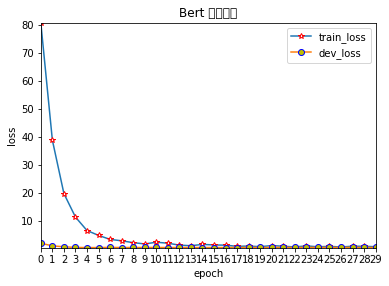

In [20]:
# encoding=utf-8
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] 

 
names = range(0,30)
names = [str(x) for x in list(names)]
 
x = range(len(names))
#plt.plot(x, y, 'ro-')
#plt.plot(x, y1, 'bo-')
#pl.xlim(-1, 11)  # 限定横轴的范围
#pl.ylim(-1, 110)  # 限定纵轴的范围
 
plt.plot(x, train_, marker='*', mec='r', mfc='w',label='train_loss')
plt.plot(x, dev_, marker='o', mec='b', mfc='y',label='dev_loss')
plt.legend()  # 让图例生效
plt.xticks(x, names, rotation=1)
 
plt.margins(0)
plt.subplots_adjust(bottom=0.10)
plt.xlabel('epoch') #X轴标签
plt.ylabel("loss") #Y轴标签
#pyplot.yticks([0.0075,0.800,50])
plt.title("Bert 训练曲线")
#plt.savefig('D:\\f1.jpg',dpi = 900)

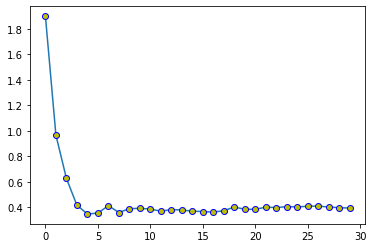

In [21]:
plt.plot(x, dev_, marker='o', mec='b', mfc='y',label='dev_loss')

In [36]:
import torch

key = {
    0: 'med_use',
    1: 'med_con',
    2: 'med_sym',
    3: 'sym_med',
    4: 'unknown'
}


config = Config('../cyx＆xy/bert/THUCNews')
model = Model(config).to(config.device)
model.load_state_dict(torch.load(config.save_path, map_location='cpu'))


def build_predict_text(text):
    token = config.tokenizer.tokenize(text)
    token = ['[CLS]'] + token
    seq_len = len(token)
    mask = []
    token_ids = config.tokenizer.convert_tokens_to_ids(token)
    pad_size = config.pad_size
    if pad_size:
        if len(token) < pad_size:
            mask = [1] * len(token_ids) + ([0] * (pad_size - len(token)))
            token_ids += ([0] * (pad_size - len(token)))
        else:
            mask = [1] * pad_size
            token_ids = token_ids[:pad_size]
            seq_len = pad_size
    ids = torch.LongTensor([token_ids]).cuda()
    seq_len = torch.LongTensor([seq_len]).cuda()
    mask = torch.LongTensor([mask]).cuda()
    return ids, seq_len, mask


def predict(text):
    """
    单个文本预测
    :param text:
    :return:
    """
    data = build_predict_text(text)
    with torch.no_grad():
        outputs = model(data)
        num = torch.argmax(outputs)
    return int(num),key[int(num)]


In [60]:
f=open('../cyx＆xy/bert/THUCNews/data/test.txt','r',encoding='utf-8')
test_set=f.readlines()
sen=[]
gold=[]
for i in test_set:
    temp=i.replace('\n','')
    temp=temp.split('\t')
    sen.append(temp[0])
    gold.append(int(temp[1]))

In [61]:
pre=[]
for i in sen:
    cate = predict(i)[0]
    pre.append(cate)

In [62]:
print(metrics.classification_report(gold, pre, target_names=config.class_list, digits=4))

              precision    recall  f1-score   support

     med_use     0.8750    0.6087    0.7179        23
     med_con     0.8214    0.8846    0.8519        26
     med_sym     0.9143    0.9697    0.9412        33
     sym_med     0.9524    0.9524    0.9524        21
     unknown     0.8000    0.9412    0.8649        17

    accuracy                         0.8750       120
   macro avg     0.8726    0.8713    0.8656       120
weighted avg     0.8771    0.8750    0.8702       120



In [81]:
ques=input()
print(predict(ques))

，SYM，SYM怎么办，小儿？
(3, 'sym_med')


In [ ]:
SYM怎么办，小儿